<a href="https://colab.research.google.com/github/boseull/tensorflow_example/blob/main/tensorflow_%EC%9D%B4%EB%AF%B8%EC%A7%80_%EB%A1%9C%EB%93%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 설정

In [3]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

print(tf.__version__)

2.5.0


꽃 데이터세트 다운

In [4]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url, fname='flower_photos', untar=True)

data_dir = pathlib.Path(data_dir)

In [5]:
data_dir

PosixPath('/root/.keras/datasets/flower_photos')

In [6]:
image_count = len(list(data_dir.glob('*/*.jpg'))) #data_dir 하위 폴더의 모든 jpg 파일 수
print(image_count)

3670


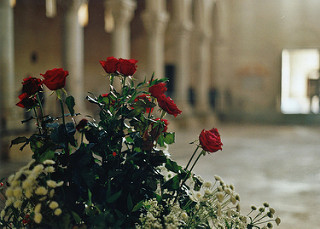

In [7]:
roses = list(data_dir.glob('roses/*')) #data_dir 중 roses 하위 파일을 list에 저장 
PIL.Image.open(str(roses[0]))

pathlib : 파일 경로를 다루기 위한 라이브러리

## 데이터세트 만들기

In [8]:
batch_size = 32
img_height = 180
img_width = 180

In [9]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir, validation_split=0.2, subset="training", seed=123, image_size=(img_height, img_width), batch_size=batch_size)
#subset : training, validation 구분 seed : shuffle을 위한 random seed


Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [10]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir, validation_split=0.2, subset="validation", seed=123, image_size=(img_height, img_width), batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [11]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


##데이터 시각화하기

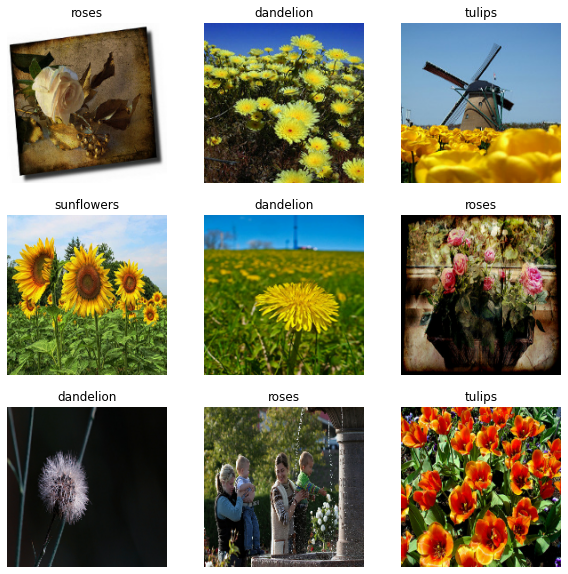

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

훈련 세트의 처음 9개 이미지

In [13]:
for image_batch, labels_batch in train_ds: 
  print(image_batch.shape) #사진 32장 180*180
  print(labels_batch.shape) #라벨 32개
  break

(32, 180, 180, 3)
(32,)


##데이터 표준화하기  
rgb 0-255 -> 0-1

In [14]:
from tensorflow.keras import layers

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [15]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)) #lambda : 함수 만들기
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

print(np.min(first_image), np.max(first_image))

0.0 0.96902645


다운사이징 하는 층을 만들어서 map으로 layer에 대입

##성능을 위한 데이터세트 구성하기

.cache : 첫 번째 epoch동안 디스크에서 이미지를 로드한 후 메모리에 유지. 데이터 병목상태 방지. 데이터가 클 경우 이 메서드를 사용하여 성능이 높은 캐시 생성  
.prefetch : 훈련 중에 데이터 전처리 및 모델 실행와 겹침

In [16]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

##모델 훈련하기


In [17]:
num_classes = 5

model = tf.keras.Sequential([
                             layers.experimental.preprocessing.Rescaling(1./255),
                             layers.Conv2D(32, 3, activation='relu'),
                             layers.MaxPooling2D(),
                             layers.Conv2D(32, 3, activation='relu'),
                             layers.MaxPool2D(),
                             layers.Conv2D(32, 3, activation='relu'),
                             layers.MaxPool2D(),
                             layers.Flatten(),
                             layers.Dense(128, activation='relu'),
                             layers.Dense(num_classes)
])

In [18]:
model.compile(optimizer='adam', loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [19]:
model.fit(train_ds, batch_size=batch_size, validation_data=val_ds, epochs=3)

Epoch 1/3
92/92 [==============================] - 39s 73ms/step - loss: 1.3232 - accuracy: 0.4332 - val_loss: 1.1162 - val_accuracy: 0.5341
Epoch 2/3
92/92 [==============================] - 2s 23ms/step - loss: 1.0684 - accuracy: 0.5739 - val_loss: 1.0450 - val_accuracy: 0.5940
Epoch 3/3
92/92 [==============================] - 2s 22ms/step - loss: 0.9515 - accuracy: 0.6247 - val_loss: 0.9439 - val_accuracy: 0.6240


##미세 제어를 위해 tf.data 사용하기

keras.preprocession : 편리한 방법  
tf.data : 자체 입력 파이프라인 작성 가능. 세밀한 제어

In [20]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [21]:
for f in list_ds.take(5):
  print(f.numpy())

b'/root/.keras/datasets/flower_photos/daisy/2590291468_2635d3e4e0_n.jpg'
b'/root/.keras/datasets/flower_photos/dandelion/2674176237_e265ea64cc_n.jpg'
b'/root/.keras/datasets/flower_photos/tulips/8733586143_3139db6e9e_n.jpg'
b'/root/.keras/datasets/flower_photos/sunflowers/4414080766_5116e8084e.jpg'
b'/root/.keras/datasets/flower_photos/roses/7251352826_69b62cba2c_m.jpg'


In [22]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names) #class_names 목록

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


In [23]:
val_size = int(image_count * 0.2) #훈련셋, 검증셋 분할
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

In [24]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy()) #데이터 세트 길이


2936
734


In [25]:
def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep) #경로를 list로 나눔
  one_hot = parts[-2] == class_names #마지막에서 두번째 부분이 class_names
  #print(parts)
  return tf.argmax(one_hot) #one-hot중 가장 큰 값의 인덱스 반환

In [26]:
def decode_img(img):
  img = tf.image.decode_jpeg(img, channels=3) #이미지 읽기
  return tf.image.resize(img, [img_height, img_width]) #이미지 리사이징 후 반환

In [27]:
def process_path(file_path):
  label = get_label(file_path) #라벨 얻기
  img = tf.io.read_file(file_path) 
  img = decode_img(img) #이미지
  return img, label #이미지와 라벨 반환

In [28]:
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [29]:
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  1


##성능을 위한 데이터세트 구성하기



*   잘 섞는다
*   배치 처리한다
*   가능한 빨리 배치 사용



In [31]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

##데이터 시각화하기

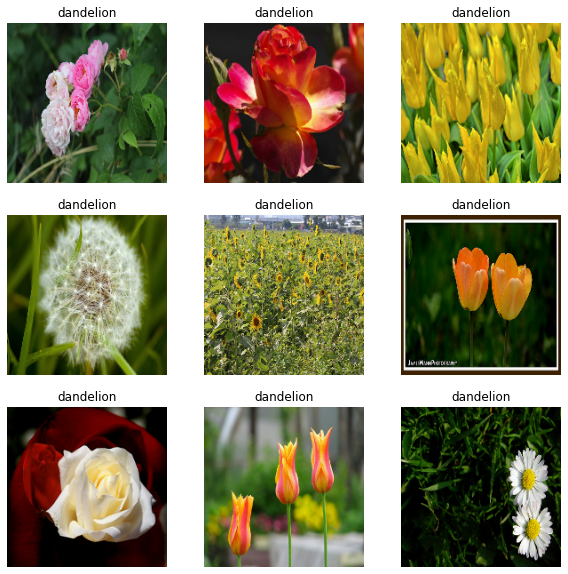

In [32]:
image_batch, labels_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i+1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  lable = labels_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

##모델 계속 훈련하기

In [34]:
model.fit(train_ds, validation_data=val_ds, epochs=3)

Epoch 1/3
92/92 [==============================] - 10s 96ms/step - loss: 0.8398 - accuracy: 0.6693 - val_loss: 0.7692 - val_accuracy: 0.7057
Epoch 2/3
92/92 [==============================] - 2s 25ms/step - loss: 0.6591 - accuracy: 0.7415 - val_loss: 0.7461 - val_accuracy: 0.7044
Epoch 3/3
92/92 [==============================] - 2s 25ms/step - loss: 0.5037 - accuracy: 0.8127 - val_loss: 0.7832 - val_accuracy: 0.6962


##tensorflow 데이터세트 사용하기

In [37]:
(train_ds, val_ds, test_ds), metadata = tfds.load('tf_flowers', split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'], with_info=True, as_supervised=True)

In [38]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

5


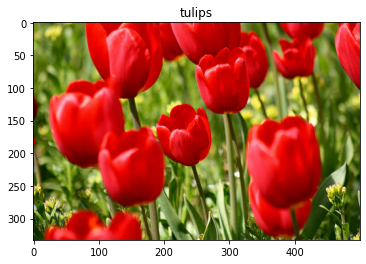

In [39]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

In [40]:
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
test_ds = configure_for_performance(test_ds)